# Traffic Sign Classifier
---


# Load The Data

Traffic sign image and labels come from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)


In [22]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import time
import glob
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from skimage import io


In [23]:
# Load pickled data

sign_labels = np.array(["Speed limit (20km/h)","Speed limit (30km/h)","Speed limit (50km/h)","Speed limit (60km/h)","Speed limit (70km/h)","Speed limit (80km/h)","End of speed limit (80km/h)","Speed limit (100km/h)","Speed limit (120km/h)","No passing","No passing for vehicles over 3.5 metric tons","Right-of-way at the next intersection","Priority road","Yield","Stop","No vehicles","Vehicles over 3.5 metric tons prohibited","No entry","General caution","Dangerous curve to the left","Dangerous curve to the right","Double curve","Bumpy road","Slippery road","Road narrows on the right","Road work","Traffic signals","Pedestrians","Children crossing","Bicycles crossing","Beware of ice/snow","Wild animals crossing","End of all speed and passing limits","Turn right ahead","Turn left ahead","Ahead only","Go straight or right","Go straight or left","Keep right","Keep left","Roundabout mandatory","End of no passing","End of no passing by vehicles over 3.5 metric tons"])


training_file = 'traffic_sign_data/train.p'
testing_file = 'traffic_sign_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
X_train_original, y_train_original = train['features'], train['labels']
X_test_original, y_test_original = test['features'], test['labels']



---

# Data Exploration

The pickled data is a dictionary with 2 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.


In [24]:

n_train_original = len(X_train_original)

n_test = len(X_test_original)

# Shape of an traffic sign image
image_shape = X_train_original[0].shape

# Number of unique classes/labels in the dataset
uniques = set().union(y_test_original, y_train_original)
n_classes = len(uniques)

print("Number of training images: ", n_train_original)
print("Number of test images: ", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training images:  39209
Number of test images:  12630
Image data shape = (32, 32, 3)
Number of classes = 43


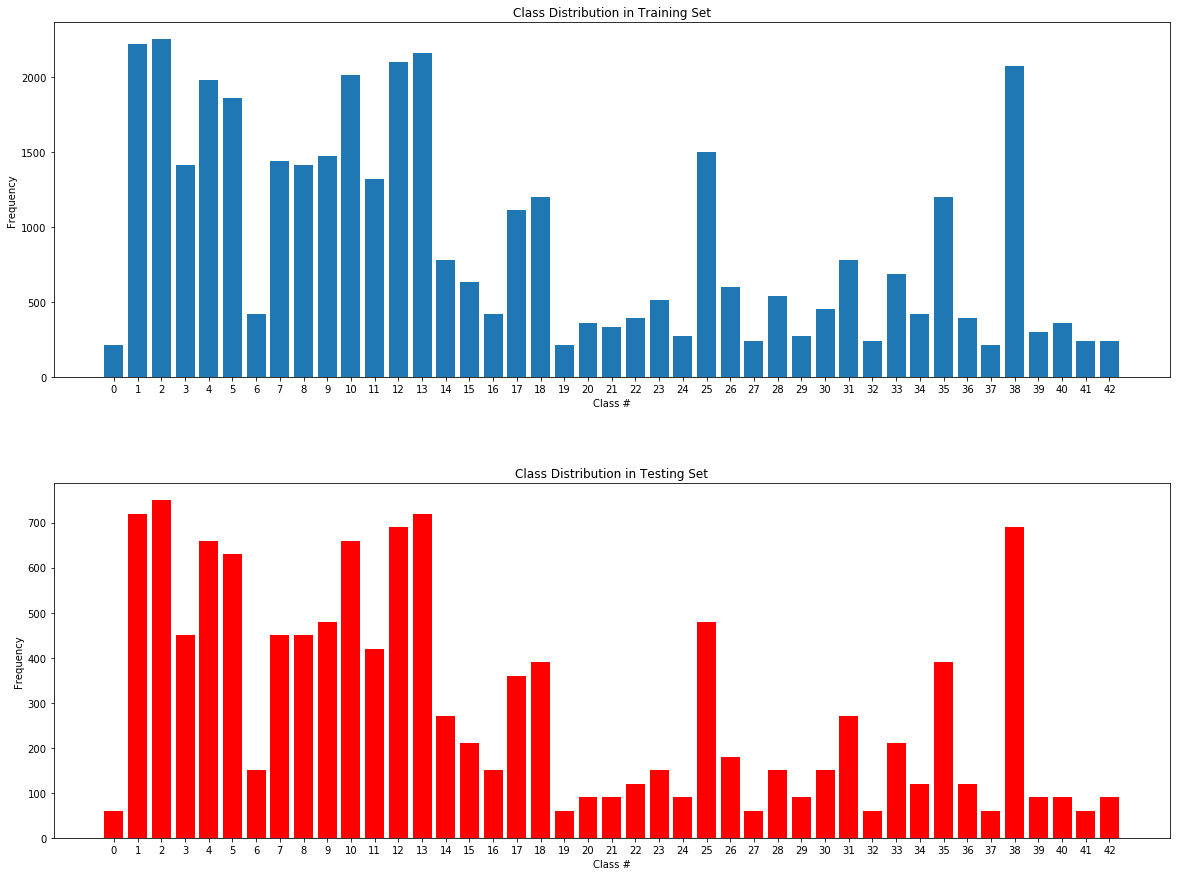

In [25]:
######
# Training set and testing set class distributions
######
fig, ax = plt.subplots(2, figsize=(20,15))
fig.subplots_adjust(hspace = .3)
labels, counts = np.unique(y_train_original, return_counts=True)
ax[0].bar(labels, counts)
ax[0].set_xticks(np.arange(43))
ax[0].set_xticklabels(labels)
ax[0].set_xlabel('Class #')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Class Distribution in Training Set')
labels, counts = np.unique(y_test_original, return_counts=True)
ax[1].bar(labels, counts, color='red')
ax[1].set_xticks(np.arange(43))
ax[1].set_xticklabels(labels)
ax[1].set_xlabel('Class #')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Class Distribution in Testing Set')

plt.show()


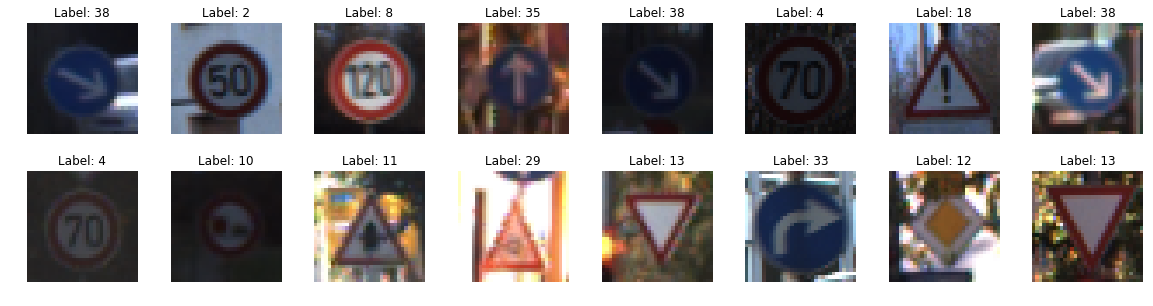

In [26]:

####
# Example images from the dataset
####
fig, axs = plt.subplots(2,8, figsize=(20,5))
fig.subplots_adjust(hspace = .2, wspace=.3)
axs = axs.ravel()
for i in range(0,16):
    index = random.randint(0, len(X_train_original))
    image = X_train_original[index].squeeze()
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title("Label: %d" % y_train_original[index])


# Data Augmentation

For every image in the original training set, apply random brightness, affine warp, and translation to create 3 additional training images. 

See Data_Augmentation.ipynb for details


In [27]:
training_augmented_file = 'traffic_sign_data/train_augmented.p'
with open(training_augmented_file, mode='rb') as f:
    train_augmented = pickle.load(f)
    
X_train_augmented, y_train_augmented = train_augmented['features'], train_augmented['labels']

n_train_augmented = len(X_train_augmented)

print("Number of training images BEFORE augmentation: ", n_train_original)
print("Number of training images AFTER augmentation: ", n_train_augmented)


Number of training images BEFORE augmentation:  39209
Number of training images AFTER augmentation:  156836


# Preprocessing

Preprocessing
* Grayscale
* Histogram Equalization
* Normalization

In [28]:


def preprocess(images):
    """
    Apply grayscale, histogram equalization, and pixel normalization on images

    Arguments:
        * images: Image data - each image should be 32x32x3

    Returns:
        *  Preprocessed image reshaped to 32x32
    """
    length = len(images)
    processed = np.empty([length, 32, 32])
    for i in range(length):
        img = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY) #grayscale
        processed[i] = cv2.equalizeHist(img) # histogram equalization
        
            
    processed = (processed - 127.5)/127.5 # normalize [-1, 1]
    
    processed = np.expand_dims(processed, axis=3)
    return processed


########################################
# Preprocess trainging and testing data
########################################
X_train_preprocessed = preprocess(X_train_augmented)
X_test_preprocessed = preprocess(X_test_original)

dist_pickle = {}
dist_pickle["features"] = X_train_preprocessed
dist_pickle["labels"] = y_train_augmented
pickle.dump(dist_pickle, open("traffic_sign_data/train_preprocessed.p", "wb"))

dist_pickle = {}
dist_pickle["features"] = X_test_preprocessed
dist_pickle["labels"] = y_test_original
pickle.dump(dist_pickle, open("traffic_sign_data/test_preprocessed.p", "wb"))
    



Original image shape:  (32, 32, 3)
Preprocessed image shape:  (32, 32, 1)


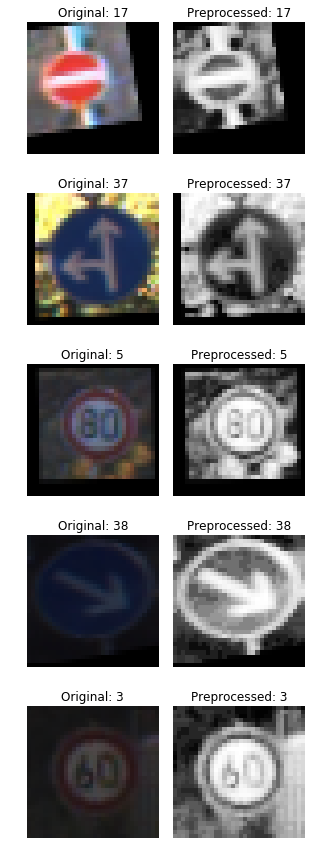

In [29]:

def visualize_preprocessing(original, preprocessed, labels):
    fig, axs = plt.subplots(5,2, figsize=(5,15))
    fig.subplots_adjust(hspace = .3, wspace=.1)
    axs = axs.ravel()
    
    print("Original image shape: ", original[0].shape)
    print("Preprocessed image shape: ", preprocessed[0].shape)
    for i in range(0,9,2):
        index = random.randint(0, len(original))
        original_img = original[index]
        axs[i].imshow(original_img)
        axs[i].axis('off')
        axs[i].set_title("Original: %d" % labels[index])
        preprocessed_img = preprocessed[index].squeeze()
        axs[i+1].imshow(preprocessed_img, cmap='gray')
        axs[i+1].axis('off')
        axs[i+1].set_title("Preprocessed: %d" % labels[index])

visualize_preprocessing(X_train_augmented, X_train_preprocessed, y_train_augmented)


# Model Architecture

In [30]:
########################
# LeNet-5 architecture
########################
def LeNet5(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)


    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)



    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(pool)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits




In [31]:
########################
# Architecture
########################
def Modified_LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x16. Output = 15x15x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 15x15x16. Output = 14x14x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 14x14x32. Output = 7x7x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 7x7x32. Output = 1568.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 1568. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1568, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits, conv1, conv2, fc1, fc2

In [32]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [37]:
## Network hyperparameters
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.001
KEEP_PROB = 0.5
TEST_SIZE = 0.2
SAVE_PATH = './modified_lenet5'

## TensorFlow placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)   

## Define model architecture
#logits = LeNet5(x)
logits, conv1, conv2, fc1, fc2 = Modified_LeNet(x)


## define loss function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)


## define evaluation / accuracy operations
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


saver = tf.train.Saver()
accuracy_history = []


## Load preprocessed training and testing sets
training_file = 'traffic_sign_data/train_preprocessed.p'
testing_file = 'traffic_sign_data/test_preprocessed.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

#################
# Train the model
#################
def train_model():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        print("Training...")
        print()

        sss = StratifiedShuffleSplit(n_splits=EPOCHS, test_size=TEST_SIZE, random_state=0)
        epoch_num = 0
        for train_index, test_index in sss.split(X_train, y_train):
            start_time = time.time()
            X_, y_ = X_train[train_index], y_train[train_index]
            num_examples = len(X_)
            
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x, batch_y = X_[offset:offset+BATCH_SIZE], y_[offset:offset+BATCH_SIZE]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})

            training_accuracy = evaluate(X_, y_)

            X_validation, y_validation = X_train[test_index], y_train[test_index] 

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(epoch_num+1))
            print("Training Accuracy = {:.3f}".format(training_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            elapsed_time = time.time()-start_time
            print("Elapsed Time: %.2f sec" % elapsed_time)
            print()

            epoch_num += 1


            accuracy_history.append((training_accuracy, validation_accuracy))

        saver.save(sess, SAVE_PATH)
        print("Model saved")
    
    
train_model()

Training...

EPOCH 1 ...
Training Accuracy = 0.743
Validation Accuracy = 0.735
Elapsed Time: 86.17 sec

EPOCH 2 ...
Training Accuracy = 0.857
Validation Accuracy = 0.844
Elapsed Time: 72.53 sec

EPOCH 3 ...
Training Accuracy = 0.910
Validation Accuracy = 0.900
Elapsed Time: 73.48 sec

EPOCH 4 ...
Training Accuracy = 0.927
Validation Accuracy = 0.920
Elapsed Time: 76.00 sec

EPOCH 5 ...
Training Accuracy = 0.943
Validation Accuracy = 0.936
Elapsed Time: 72.06 sec

EPOCH 6 ...
Training Accuracy = 0.950
Validation Accuracy = 0.940
Elapsed Time: 72.52 sec

EPOCH 7 ...
Training Accuracy = 0.964
Validation Accuracy = 0.957
Elapsed Time: 71.88 sec

EPOCH 8 ...
Training Accuracy = 0.969
Validation Accuracy = 0.962
Elapsed Time: 71.84 sec

EPOCH 9 ...
Training Accuracy = 0.973
Validation Accuracy = 0.968
Elapsed Time: 73.42 sec

EPOCH 10 ...
Training Accuracy = 0.978
Validation Accuracy = 0.973
Elapsed Time: 77.35 sec

EPOCH 11 ...
Training Accuracy = 0.977
Validation Accuracy = 0.973
Elapsed T

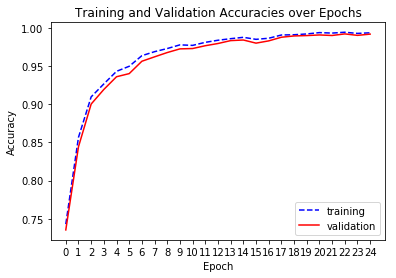

In [38]:

#accuracy_shortened = accuracy_history[1:]
hist = np.transpose(np.array(accuracy_history))
train_history = hist[0]
t, = plt.plot(train_history, 'b', linestyle='--', label='training')
validation_history = hist[1]
v, = plt.plot(validation_history, 'r', label='validation') 
plt.legend(handles=[t, v])
plt.title('Training and Validation Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(EPOCHS))
plt.show()




In [39]:
with tf.Session() as sess:
    saver.restore(sess, save_path=SAVE_PATH)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./modified_lenet5
Test Accuracy = 0.949


INFO:tensorflow:Restoring parameters from ./modified_lenet5
(1, 32, 32, 1)


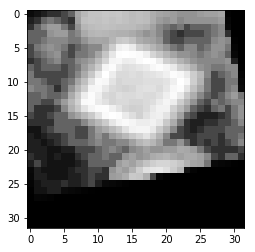

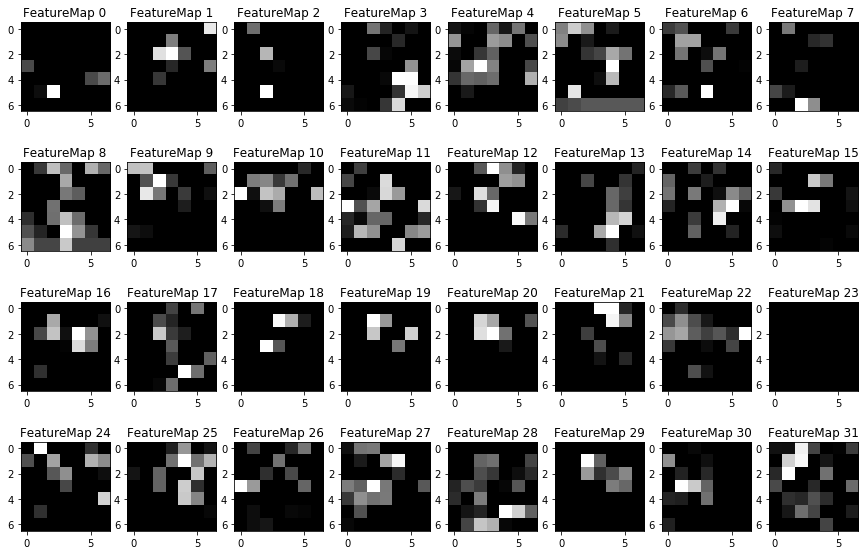

In [52]:
### Visualize feature maps


def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):

    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
with tf.Session() as sess:
    saver.restore(sess, save_path=SAVE_PATH)
    index = np.random.randint(0,len(X_train))
    img = X_train[index]
    test_image = np.expand_dims(img, axis=0)
    print(test_image.shape)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.show()
    outputFeatureMap(test_image, conv2)

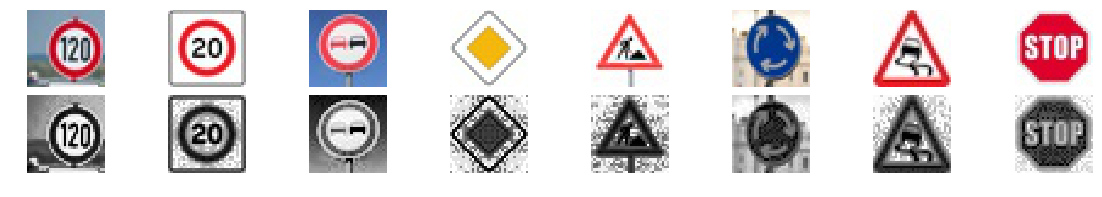

In [116]:
def get_new_signs():
    new_image_names = glob.glob('./signs/*.jpg')
    length = len(new_image_names)
    new_images = np.empty([length, 32, 32, 3])

    fig, axs = plt.subplots(2,8, figsize=(20,3))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    
    for i, name in enumerate(new_image_names):
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_images[i] = img
        axs[i].imshow(img)
        axs[i].axis('off')
        
    new_images = np.array(new_images, dtype=np.uint8)
        
    preprocessed_images =  preprocess(new_images)
    for i, img in enumerate(preprocessed_images):
        axs[i+length].imshow(img.squeeze(), cmap='gray')
        axs[i+length].axis('off')
        
    plt.show()    
    return preprocessed_images, new_images
    
new_preprocessed_images, new_images_original = get_new_signs()


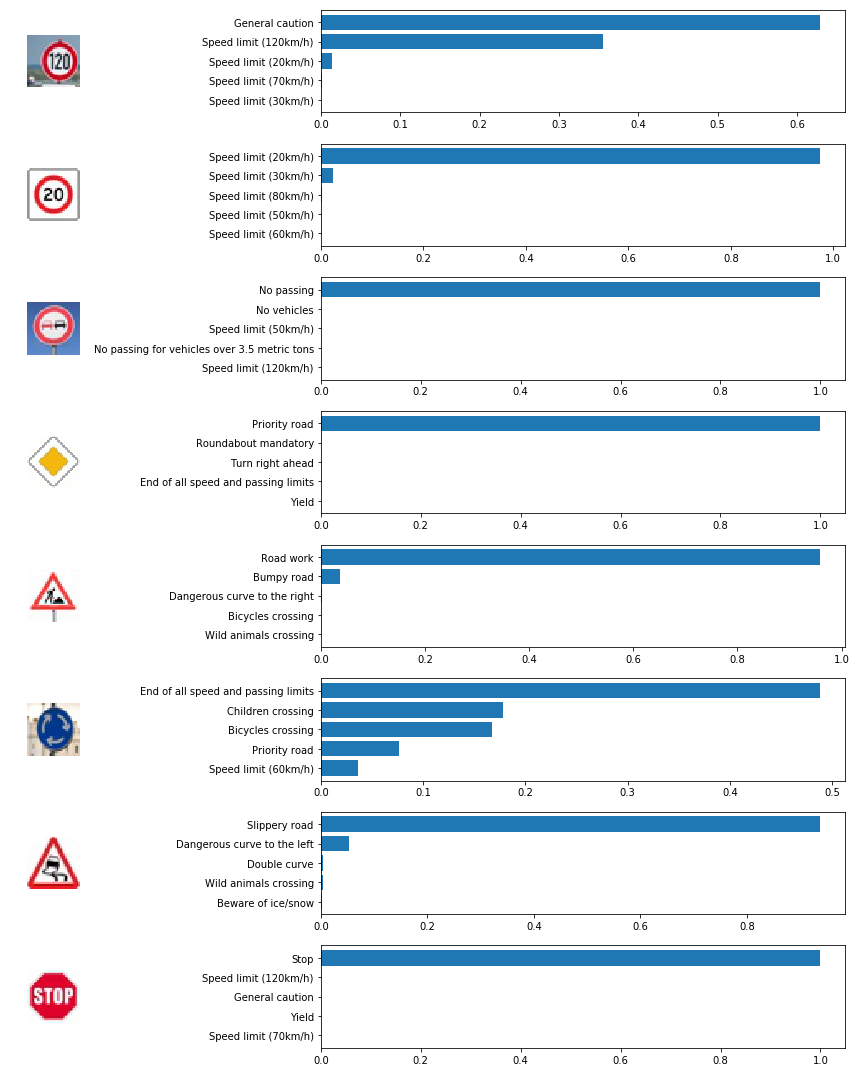

In [117]:
#####################################
# Visualize the softmax probabilities
#####################################
from matplotlib import gridspec

with tf.Session() as sess:
    saver.restore(sess, save_path=SAVE_PATH)

    ## Define top_k operation
    sftmax = tf.nn.softmax(logits)
    top_k_operation = tf.nn.top_k(sftmax, 5, sorted=True)

    top_k_results = sess.run(top_k_operation, feed_dict={x: new_preprocessed_images, keep_prob: 1})
    
    top_k_values = top_k_results[0]
    top_k_indices = top_k_results[1]
    
    
    
    fig, axs = plt.subplots(8,2, figsize=(12,15))
    fig.subplots_adjust(hspace = .3, wspace=.4)
    gs = gridspec.GridSpec(8, 2, width_ratios=[1,10])
    axs = axs.ravel()
    
    for i in range(0, 15, 2):
        axs[i] = plt.subplot(gs[i])
        axs[i].imshow(new_images_original[int(i/2)])
    
        axs[i].axis('off')
        axs[i+1] = plt.subplot(gs[i+1])
        axs[i+1].barh(np.arange(5), top_k_values[int(i/2)])
        sign_label_indices = top_k_indices[int(i/2)]
        axs[i+1].set_yticks(np.arange(5))
        axs[i+1].set_yticklabels(sign_labels[sign_label_indices])
        axs[i+1].invert_yaxis()
    plt.tight_layout()
    
    plt.show()